# Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [3]:
import torch
from torch.utils.data import Subset, DataLoader

from torchvision import tv_tensors
from torchvision.io import decode_image
from torchvision.ops import box_iou
from torchvision.transforms import v2 as T
from torchvision.transforms.v2.functional import to_dtype, get_size, convert_bounding_box_format

from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import pandas as pd
import numpy as np

import os
import json

import math
import sys

import utils
from engine import train_one_epoch, evaluate

# Data

In [4]:
class AerialImageryDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir_path, annotation_path, background_weight, train=False):
        self.image_dir_path = image_dir_path

        self.transforms = []
        if train:
            self.transforms.append(T.RandomHorizontalFlip(p=0.5))
            self.transforms.append(T.RandomVerticalFlip(p=0.5))

        self.transforms.append(T.ToDtype(torch.float, scale=True))
        self.transforms.append(T.ToPureTensor())
        self.transforms = T.Compose(self.transforms)

        self.label_map = {"daylighting": 1,
                          "safety_islands": 2,
                          "curb_extensions": 3}

        with open(annotation_path) as json_file:
            self.annotations = json.load(json_file)

        self.weights = []

        for item in tqdm(self.annotations):
            curr_weight = 1

            if "label" in item:
                for label in item["label"]:
                    if label["rectanglelabels"][0] == "curb_extensions":
                        curr_weight = 3
                        break
            else:
                curr_weight = background_weight

            self.weights.append(curr_weight)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.image_dir_path,
            self.annotations[idx]["image"].split("%5C")[-1])

        img = decode_image(img_path, mode="RGB")

        if img.dtype != torch.float:
            img = to_dtype(img, dtype=torch.float, scale=True)

        img = tv_tensors.Image(img)

        if "label" in self.annotations[idx]:
            boxes = [[
                i["x"],
                i["y"],
                i["width"],
                i["height"]] for i in self.annotations[idx]["label"]]

            boxes = convert_bounding_box_format(tv_tensors.BoundingBoxes(boxes, format="XYWH", canvas_size=get_size(img)), new_format="XYXY")
            boxes = tv_tensors.BoundingBoxes(boxes * 416 / 100, format="XYXY", canvas_size=get_size(img))
            labels = torch.tensor([self.label_map[i["rectanglelabels"][0]] for i in self.annotations[idx]["label"]])

        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = int("".join(self.annotations[idx]["image"].split("%5C")[-1].split(".")[0].split("_")))
        target["area"] = torch.tensor([(box[2] - box[0]) * (box[3] - box[1]) for box in boxes])
        target["iscrowd"] = torch.tensor([0] * len(boxes))

        img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations)

In [5]:
class AerialImageryDatasetOneClass(AerialImageryDataset):
    def __init__(self, image_dir_path, annotation_path, background_weight, class_label, train=False):
        self.image_dir_path = image_dir_path

        self.transforms = []
        if train:
            self.transforms.append(T.RandomHorizontalFlip(p=0.5))
            self.transforms.append(T.RandomVerticalFlip(p=0.5))

        self.transforms.append(T.ToDtype(torch.float, scale=True))
        self.transforms.append(T.ToPureTensor())
        self.transforms = T.Compose(self.transforms)

        self.label_map = {"daylighting": 1,
                          "safety_islands": 2,
                          "curb_extensions": 3}
        self.class_label = class_label


        with open(label_path) as json_file:
            self.annotations = json.load(json_file)

        for anno in self.annotations:
            if "label" in anno:
                anno["label"] = [i for i in anno["label"] if i["rectanglelabels"][0] == class_label]

                if len(anno["label"]) == 0:
                    del anno["label"]

        self.weights = []

        for item in tqdm(self.annotations):
            curr_weight = 1

            if "label" not in item:
                curr_weight = background_weight

            self.weights.append(curr_weight)

In [6]:
from tqdm import tqdm

image_path = os.path.join("/content/gdrive/My Drive/Grad School/Dissertation/Data", "test")
label_path = os.path.join("/content/gdrive/My Drive/Grad School/Dissertation/Data", "test.json")

batch_size = 32

dataset_train = AerialImageryDataset(
    image_dir_path=image_path,
    annotation_path=label_path,
    background_weight=0.001,
    train=True)
dataset_valtest = AerialImageryDataset(
    image_dir_path=image_path,
    annotation_path=label_path,
    background_weight=0.001,
    train=False)


g = torch.Generator()
g.manual_seed(2025)
indices = torch.randperm(n=len(dataset_train), generator=g).tolist()

subset_train = Subset(dataset_train, indices[:int(len(dataset_train) * 0.8)])
subset_val = Subset(dataset_valtest, indices[int(len(dataset_valtest) * 0.8):int(len(dataset_valtest) * 0.9)])
subset_test = Subset(dataset_valtest, indices[int(len(dataset_valtest) * 0.9):])

train_weights = [dataset_train.weights[idx] for idx in indices[:int(len(dataset_train) * 0.8)]]

data_loader_train = DataLoader(
    subset_train,
    batch_size=batch_size,
    sampler=torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights)),
    collate_fn=utils.collate_fn
)
data_loader_val = DataLoader(
    subset_val,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

data_loader_test = DataLoader(
    subset_test,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

###
annotated_indices = []
unannotated_indices = []

for i in subset_val.indices:
    if "label" in subset_val.dataset.annotations[i]:
        annotated_indices.append(i)
    else:
        unannotated_indices.append(i)

subset_val_annotated = Subset(dataset_valtest, annotated_indices)
subset_val_unannotated = Subset(dataset_valtest, unannotated_indices)

data_loader_val_annotated = DataLoader(
    subset_val_annotated,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

data_loader_val_unannotated = DataLoader(
    subset_val_unannotated,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

###

dataset_daylight = AerialImageryDatasetOneClass(
    image_dir_path=image_path,
    annotation_path=label_path,
    background_weight=0.001,
    class_label="daylighting",
    train=False)
dataset_island = AerialImageryDatasetOneClass(
    image_dir_path=image_path,
    annotation_path=label_path,
    background_weight=0.001,
    class_label="safety_islands",
    train=False)
dataset_curb = AerialImageryDatasetOneClass(
    image_dir_path=image_path,
    annotation_path=label_path,
    background_weight=0.001,
    class_label="curb_extensions",
    train=False)

g = torch.Generator()
g.manual_seed(2025)
indices = torch.randperm(n=len(dataset_train), generator=g).tolist()

subset_val_daylight = Subset(dataset_daylight, indices[int(len(dataset_valtest) * 0.8):int(len(dataset_valtest) * 0.9)])
subset_val_island = Subset(dataset_island, indices[int(len(dataset_valtest) * 0.8):int(len(dataset_valtest) * 0.9)])
subset_val_curb = Subset(dataset_curb, indices[int(len(dataset_valtest) * 0.8):int(len(dataset_valtest) * 0.9)])

data_loader_val_daylight = DataLoader(
    subset_val_daylight,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

data_loader_val_island = DataLoader(
    subset_val_island,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)
data_loader_val_curb = DataLoader(
    subset_val_curb,
    batch_size=batch_size,
    collate_fn=utils.collate_fn
)

100%|██████████| 5000/5000 [00:00<00:00, 3004515.76it/s]


# Evaluation

In [7]:
model_tune = fasterrcnn_resnet50_fpn_v2(
    weights="DEFAULT")
num_classes = 4
in_features = model_tune.roi_heads.box_predictor.cls_score.in_features
model_tune.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

checkpoint_path = os.path.join(
    "/content/gdrive/My Drive/Grad School/Dissertation/Data/final checkpoints",
    "pretrain_transform_0.001_0.0001_5.pt")
checkpoint = torch.load(checkpoint_path)

model_tune.load_state_dict(checkpoint['model'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_tune.to(device)

print(f"Model loaded successfully from {checkpoint_path}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 189MB/s]


Model loaded successfully from /content/gdrive/My Drive/Grad School/Dissertation/Data/final checkpoints/pretrain_transform_0.001_0.0001_5.pt


In [8]:
evaluate(model_tune, data_loader_val_curb, device=device)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:57  model_time: 3.3766 (3.3766)  evaluator_time: 0.0093 (0.0093)  time: 3.5847  data: 0.1792  max mem: 9978
Test:  [15/16]  eta: 0:00:01  model_time: 1.6887 (1.7566)  evaluator_time: 0.0047 (0.0049)  time: 1.9670  data: 0.1873  max mem: 9987
Test: Total time: 0:00:31 (1.9673 s / it)
Averaged stats: model_time: 1.6887 (1.7566)  evaluator_time: 0.0047 (0.0049)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

In [9]:
evaluate(model_tune, data_loader_val_daylight, device=device)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:30  model_time: 1.6876 (1.6876)  evaluator_time: 0.0061 (0.0061)  time: 1.8879  data: 0.1757  max mem: 9987
Test:  [15/16]  eta: 0:00:01  model_time: 1.6968 (1.6583)  evaluator_time: 0.0057 (0.0058)  time: 1.8649  data: 0.1826  max mem: 9987
Test: Total time: 0:00:29 (1.8650 s / it)
Averaged stats: model_time: 1.6968 (1.6583)  evaluator_time: 0.0057 (0.0058)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

In [10]:
evaluate(model_tune, data_loader_val_island, device=device)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:30  model_time: 1.6803 (1.6803)  evaluator_time: 0.0059 (0.0059)  time: 1.8953  data: 0.1910  max mem: 9987
Test:  [15/16]  eta: 0:00:01  model_time: 1.6896 (1.6506)  evaluator_time: 0.0063 (0.0064)  time: 1.8595  data: 0.1845  max mem: 9987
Test: Total time: 0:00:29 (1.8596 s / it)
Averaged stats: model_time: 1.6896 (1.6506)  evaluator_time: 0.0063 (0.0064)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

# Set Confidence

In [11]:
def filter_boxes(outputs, confidence_threshold=0.5, class_label=2):
    # Filter predictions based on confidence threshold
    filtered_outputs = []
    for output in outputs:
        if "image_id" in output:
            boxes = output['boxes']
            labels = output['labels']
            image_id = output['image_id']
            area = output['area']
            iscrowd = output['iscrowd']

            filtered_indices = torch.where(labels == class_label)[0]

            filtered_outputs.append({
                'boxes': boxes[filtered_indices],
                'labels': labels[filtered_indices],
                'image_id': image_id,
                'area': area[filtered_indices],
                'iscrowd': iscrowd[filtered_indices]
            })

        else:
            scores = output['scores']
            boxes = output['boxes']
            labels = output['labels']

            filtered_indices = torch.where((scores > confidence_threshold) & (labels == 2))[0]

            filtered_outputs.append({
                'boxes': boxes[filtered_indices],
                'labels': labels[filtered_indices],
                'scores': scores[filtered_indices]
            })
    return filtered_outputs

In [12]:
def count_pos_neg(targets, filtered_outputs, iou_threshold=0.5):
    """
    Counts true positives, false postives, and false negatives for the given filtered predictions and ground truth targets.

    Args:
        targets (tuple): A tuple of dictionaries containing ground truth targets (boxes, labels, image_id, area, iscrowd).
        filtered_outputs (list): A list of dictionaries containing filtered predictions (boxes, labels, scores).
        iou_threshold (float): The Intersection over Union threshold for considering a detection a true positive.

    Returns:
        tuple: The tuple (true positives, false positives, false negatives).
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # iterate through images
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    for image_idx, target in enumerate(targets):
        gt_boxes = target["boxes"].to(device)
        pred_boxes = filtered_outputs[image_idx]["boxes"]

        iou_matrix = box_iou(gt_boxes, pred_boxes)

        for gt_box_iou in iou_matrix:
            # case: no pred boxes, gt box doesn't get matched
            if len(pred_boxes) == 0:
                false_negatives += 1
                continue

            # match gt box with pred box with highest iou
            max_iou, max_idx = torch.max(gt_box_iou, dim=0)

            # match and remove the pred box if above threshold, else gt box unmatched
            if max_iou > iou_threshold:
                iou_matrix[:, max_idx] = -1
                true_positives += 1
            else:
                false_negatives += 1

        # count unmatched pred boxes (false positives)
        # case: no gt boxes, all pred boxes are false positives
        if len(gt_boxes) == 0:
            false_positives += len(pred_boxes)
        else:
            false_positives += torch.sum(iou_matrix[0] != -1).item()

    return true_positives, false_positives, false_negatives

In [13]:
def calc_f1(confidence_threshold=0):
    tp_count, fp_count, fn_count = 0, 0, 0

    model_tune.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader_val_island):
            images = list(img.to(device) for img in images)

            outputs = model_tune(images)
            filtered_outputs = filter_boxes(outputs, confidence_threshold=confidence_threshold)

            true_positives, false_positives, false_negatives = count_pos_neg(targets, filtered_outputs)
            tp_count += true_positives
            fp_count += false_positives
            fn_count += false_negatives

    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) != 0 else 1
    recall = tp_count / (tp_count + fn_count)

    return 2 * precision * recall / (precision + recall), precision, recall

In [14]:
confidences = np.arange(0, 1, .025)
results = [calc_f1(confidence) for confidence in tqdm(confidences)]
f1_scores = [result[0] for result in results]

100%|██████████| 40/40 [19:58<00:00, 29.97s/it]


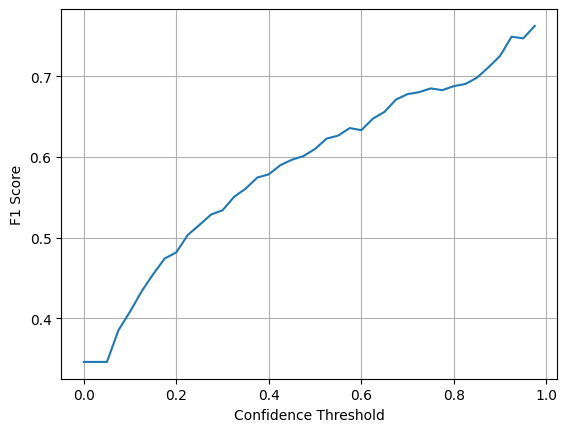

In [17]:
import matplotlib.pyplot as plt

plt.plot(confidences, f1_scores)
plt.style.use('seaborn-v0_8-paper')
plt.grid(True)
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.show()

In [16]:
precisions = [result[1] for result in results]
recalls = [result[2] for result in results]

print(
    confidences[np.argmax(f1_scores)].item(),
    np.max(f1_scores).item(),
    precisions[np.argmax(f1_scores)],
    recalls[np.argmax(f1_scores)])

0.9750000000000001 0.7623318385650224 0.8018867924528302 0.7264957264957265


# Deployment

In [ ]:
class DeploymentDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir_path, quarter=0):
        self.image_dir_path = image_dir_path

        # self.image_file_names = os.listdir(image_dir_path)
        # colab version
        import pickle
        file_path = "/content/file_names.pkl"
        with open(file_path, 'rb') as f:
            self.image_file_names = pickle.load(f)

        if quarter == 0:
            self.image_file_names = self.image_file_names[:int(len(self.image_file_names) * 0.25)]
        elif quarter == 3:
            self.image_file_names = self.image_file_names[int(len(self.image_file_names) * 3 * 0.25):]
        else:
            self.image_file_names = self.image_file_names[int(len(self.image_file_names) * 0.25 * quarter):int(len(self.image_file_names) * 0.25 * (quarter + 1))]

        self.image_file_names = [file_name for file_name in self.image_file_names if file_name not in deployment_counts]

        self.transforms = []
        self.transforms.append(T.ToDtype(torch.float, scale=True))
        self.transforms.append(T.ToPureTensor())
        self.transforms = T.Compose(self.transforms)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.image_dir_path,
            self.image_file_names[idx])

        img = decode_image(img_path, mode="RGB")

        if img.dtype != torch.float:
            img = to_dtype(img, dtype=torch.float, scale=True)

        img = tv_tensors.Image(img)

        target = self.image_file_names[idx]

        img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_file_names)

In [ ]:
image_dir_path = "/content/gdrive/My Drive/Grad School/Dissertation/All Images/all-images"

batch_size = 32

deploy_dataset = DeploymentDataset(
    image_dir_path=image_dir_path,
    quarter=3)

data_loader_deploy = DataLoader(
    deploy_dataset,
    batch_size=batch_size,
    pin_memory=True,
)

In [ ]:
# import pickle

# deployment_counts = {}
# file_path = "/content/gdrive/My Drive/Grad School/Dissertation/deployment_counts_q3.pkl"
# with open(file_path, 'wb') as f:
#     pickle.dump(deployment_counts, f)

In [ ]:
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)
loaded_dict

In [ ]:
import pickle
from tqdm import tqdm

confidence_threshold = 0.975

model_tune.eval()

file_path = "/content/gdrive/My Drive/Grad School/Dissertation/deployment_counts_q3.pkl"

with open(file_path, 'rb') as f:
    deployment_counts = pickle.load(f)

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm(data_loader_deploy)):
        images = list(img.to(device, non_blocking=True) for img in images)

        outputs = model_tune(images)
        filtered_outputs = filter_boxes(outputs, confidence_threshold=confidence_threshold)
        counts = [len(output["labels"]) for output in filtered_outputs]

        for target, count in zip(targets, counts):
            deployment_counts[target] = count

        if batch_idx % 250 == 0:
            with open(file_path, 'wb') as f:
                pickle.dump(deployment_counts, f)

  0%|          | 0/928 [02:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
next(iter(data_loader_deploy))

In [ ]:
def test():
    import pickle

    confidence_threshold = 0.975

    model_tune.eval()

    file_path = "/content/gdrive/My Drive/Grad School/Dissertation/deployment_counts.pkl"

    with open(file_path, 'rb') as f:
        deployment_counts = pickle.load(f)

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(data_loader_deploy)):
            images = list(img.to(device) for img in images)

            outputs = model_tune(images)
            filtered_outputs = filter_boxes(outputs, confidence_threshold=confidence_threshold)
            counts = [len(output["labels"]) for output in filtered_outputs]

            for target, count in zip(targets, counts):
                deployment_counts[target] = count

            if batch_idx == 30:
                break

            if batch_idx % 500 == 0:
                with open(file_path, 'wb') as f:
                    pickle.dump(deployment_counts, f)

In [ ]:
! pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.2 MB/s eta 0:00:00


In [ ]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
%lprun -f test test()

  1%|          | 30/3712 [02:59<6:07:18,  5.99s/it] 
